In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
import numpy as np
import pandas as pd
import cv2
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models
import torch.optim as optim

from network import Net

#### Load model

In [5]:
model = Net()

model.load_state_dict(torch.load('saved_models/model2.pt', map_location='cpu'))
model.eval()
print("Model succefully loaded !")

Model succefully loaded !


#### Prepare images

In [7]:
def rescale_img(image, output_size):
  
    h, w = image.shape[:2]

    if isinstance(output_size, int):
        if h > w:
            new_h, new_w = output_size * h / w, output_size
        else:
            new_h, new_w = output_size, output_size * w / h
    else:
        new_h, new_w = output_size

    new_h, new_w = int(new_h), int(new_w)

    img = cv2.resize(image, (new_w, new_h))

    return img
      
  
  
  
def normalize_img(image):
    image_copy = np.copy(image)
    image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_copy =  image_copy/255.0

    return image_copy
  
  

def tensor_img(image):
    # if image has no grayscale color channel, add one
    if(len(image.shape) == 2):
        # add that third color dim
        image = image.reshape(image.shape[0], image.shape[1], 1)

    # swap color axis because
    # numpy image: H x W x C
    # torch image: C X H X W
    image = image.transpose((2, 0, 1))

    return torch.from_numpy(image)

#### Select region of interest

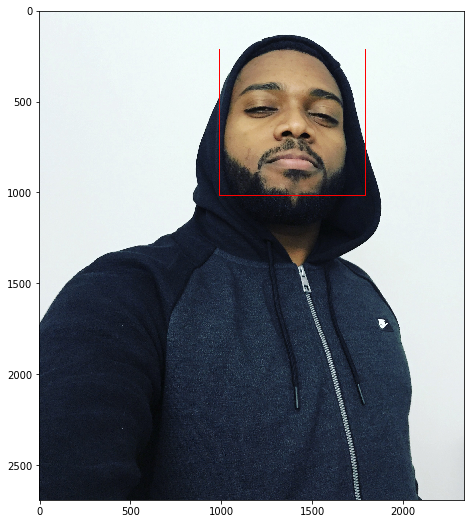

In [13]:
# Detect Face in an Image using Cascade File

image = cv2.imread('images/IMG_3529.jpg')

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

img_detection = image.copy()


face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

faces = face_cascade.detectMultiScale(img_detection, scaleFactor=1.2, minNeighbors=2)


for (x,y,w,h) in faces:
    
    cv2.rectangle(img_detection,(x,y),(x+w,y+h),(255,0,0),3)

    
fig = plt.figure(figsize=(9,9))

plt.imshow(img_detection)

#### Inference

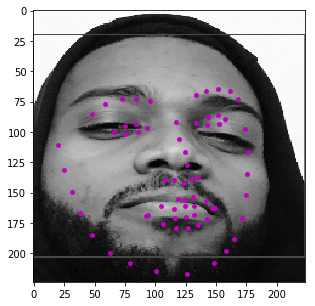

In [16]:
plt.figure(figsize=(5,5))

model.cpu()

# Loop over the detected faces
# Keep the face part using cropping
# Predict keypoint
for (x,y,w,h) in faces:
  
    image_kpts = img_detection[y-90:y+h+90, x:x+w]  
    

image_kpts = cv2.resize(image_kpts, (224,224))

image_kpts = normalize_img(image_kpts)

image_kpts = tensor_img(image_kpts)


# convert images to FloatTensors
image_kpts = image_kpts.type(torch.FloatTensor)

# forward pass to get model output
with torch.no_grad():
    output_pts = model(image_kpts.unsqueeze(0))

# reshape to batch_size x 68 x 2 pts
output_pts = output_pts.view(output_pts.size()[0], 68, -1)

#unormalize images
image_kpts = image_kpts.numpy()
image_kpts = np.transpose(image_kpts, (1, 2, 0))


#unormalize labels
labels = output_pts.numpy()
labels = labels*50.0+100
labels = labels.reshape(-1, 2)


#plt.subplot(4,5,i+1)
plt.imshow(np.squeeze(image_kpts), cmap='gray')
plt.scatter(labels[:, 0], labels[:, 1], s=60, marker='.', c='m')

#### Visualize some filter in the first conv layer

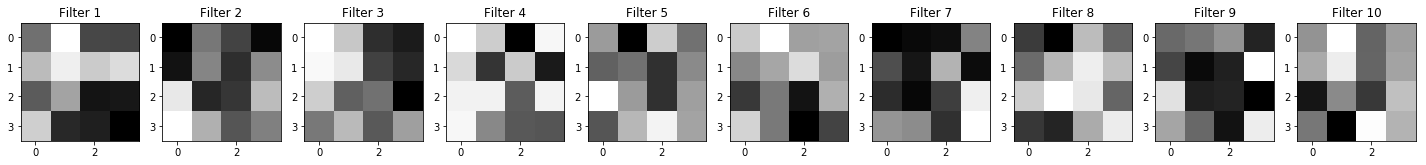

In [17]:
plt.figure(figsize=(25,20))

# weight of the first conv layer
weights1 = model.conv1.weight.data
w = weights1.numpy()

#plot the first 10 filters
for i in range(10):
    #choose a filter
    num_filter = i
    filter_w = w[num_filter][0]

    plt.subplot(1, 10, i+1)
    plt.title(f"Filter {i+1}")
    
    plt.imshow(filter_w, cmap='gray')

#### Visualize some feature maps

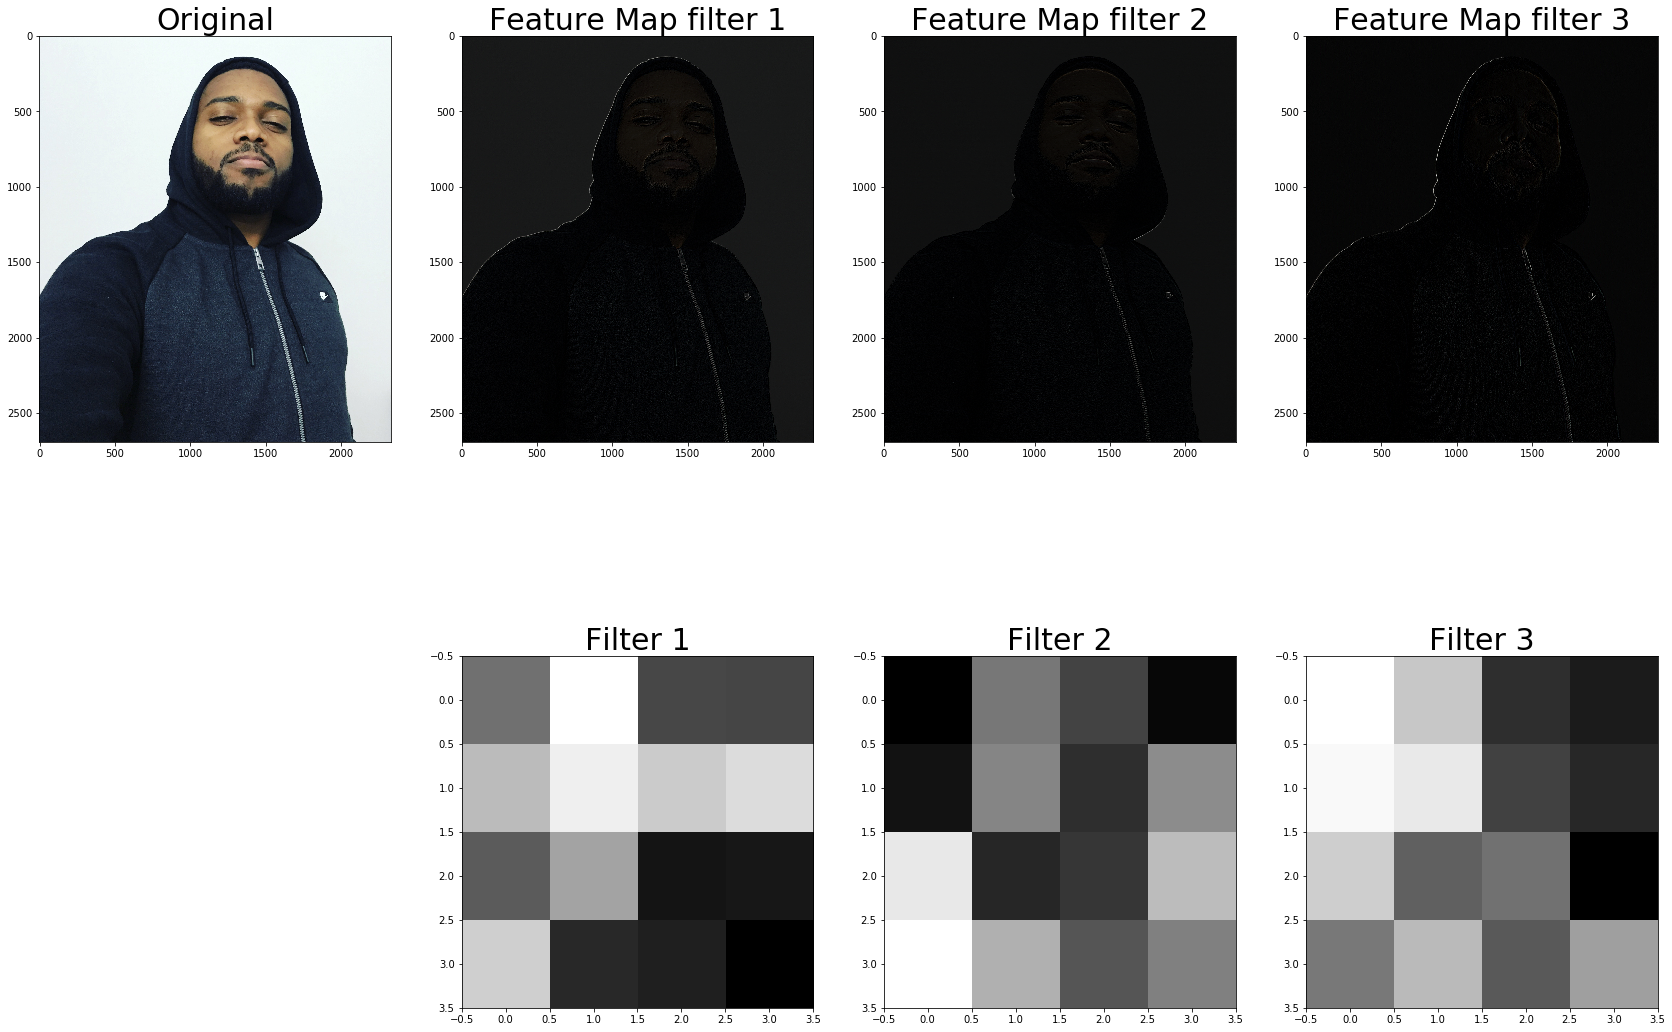

In [40]:
plt.figure(figsize=(29,20))

img = image.copy()

plt.subplot(2, 4, 1)
plt.title('Original', fontsize=30)
plt.imshow(img)

# Let's visualize some features maps

weights1 = model.conv1.weight.data
w = weights1.numpy()

# Applying the image
for i in range(3):
    num_filter = i

    filtered = cv2.filter2D(img, -1, w[num_filter][0])

    plt.subplot(2, 4, i+2)
    plt.title(f"Feature Map filter {i+1}", fontsize=30)
    plt.imshow(filtered)
    
    
    filter_w = w[num_filter][0]

    plt.subplot(2, 4, 6+i)
    plt.title(f"Filter {i+1}", fontsize=30)
    plt.imshow(filter_w, cmap='gray')

#### Try some funny stuff

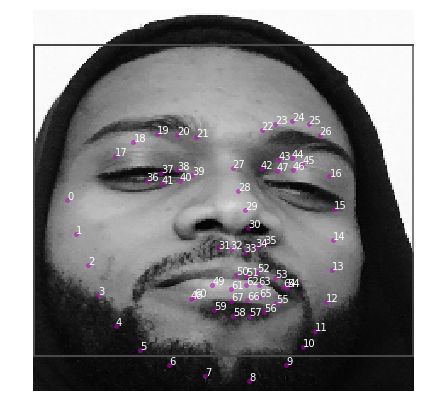

In [42]:
# Keypoints position
plt.figure(figsize=(7,7))

plt.axis('off')
plt.imshow(np.squeeze(image_kpts), cmap='gray')
plt.scatter(labels[:, 0], labels[:, 1], s=60, marker='.', c='m', alpha = 0.5)

for i in range(labels.shape[0]):
    plt.text(labels[i,0], labels[i,1], str(i), color='white')

Image shape:  (1123, 3064, 4)


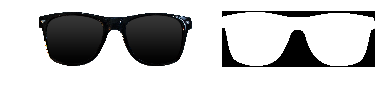

In [43]:
# load in sunglasses image with cv2 and IMREAD_UNCHANGED because we want to read the alpha channel png
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(sunglasses)
print('Image shape: ', sunglasses.shape)

# print out the sunglasses transparency (alpha) channel
alpha_channel = sunglasses[:,:,3]

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(alpha_channel, cmap='gray')

In [45]:
for (x,y,w,h) in faces:
    img = img_detection[y:y+h, x:x+w]


# point (x,y) representant la pointe du sourcil gauche
x = int(labels[17, 0])
y = int(labels[17, 1])


# h and w that we want for the sunglasse
h = int(abs(labels[27,1] - labels[34,1]))
w = int(abs(labels[17,0] - labels[26,0]))


new_sunglasses =  cv2.resize(sunglasses, (w, h), interpolation = cv2.INTER_CUBIC)

# get region of interest on the face to change
roi_color = img[y:y+h,x:x+w]

#plt.imshow(roi_color)